In [5]:
from fvm_utils import *
import os
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML


# Simulation test run

In [6]:
! bash run_Schelling2D2S_geographicArea.sh

/Users/danny/miniconda3/envs/fipy/lib/python3.10/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
Final mean-square error:
White: 0.1010
Black: 0.0085


In [15]:
savefolder = "/Users/danny/Library/CloudStorage/GoogleDrive-dsseara@uchicago.edu/My Drive/uchicago/sociohydro/2024-05-03_fipyTest"
filename = "data.hdf5"
with h5py.File(os.path.join(savefolder, filename), "r") as d:
    cell_centers = d["common"]["cell_centers"][()]
    ϕW_init = d["common"]["phiW_initial"][()]
    ϕB_init = d["common"]["phiB_initial"][()]
    ϕW_final = d["common"]["phiW_final"][()]
    ϕB_final = d["common"]["phiB_final"][()]
    nt = len(list(d.keys())) - 1

    # print(list(d.keys()).contains("n)"))
    # ϕW = d["phiW_array"][()]
    # ϕB = d["phiB_array"][()]
    # ϕW_2020 = d["phiW_2020"][()]
    # ϕB_2020 = d["phiB_2020"][()]
    # t = d["t_array"][()]

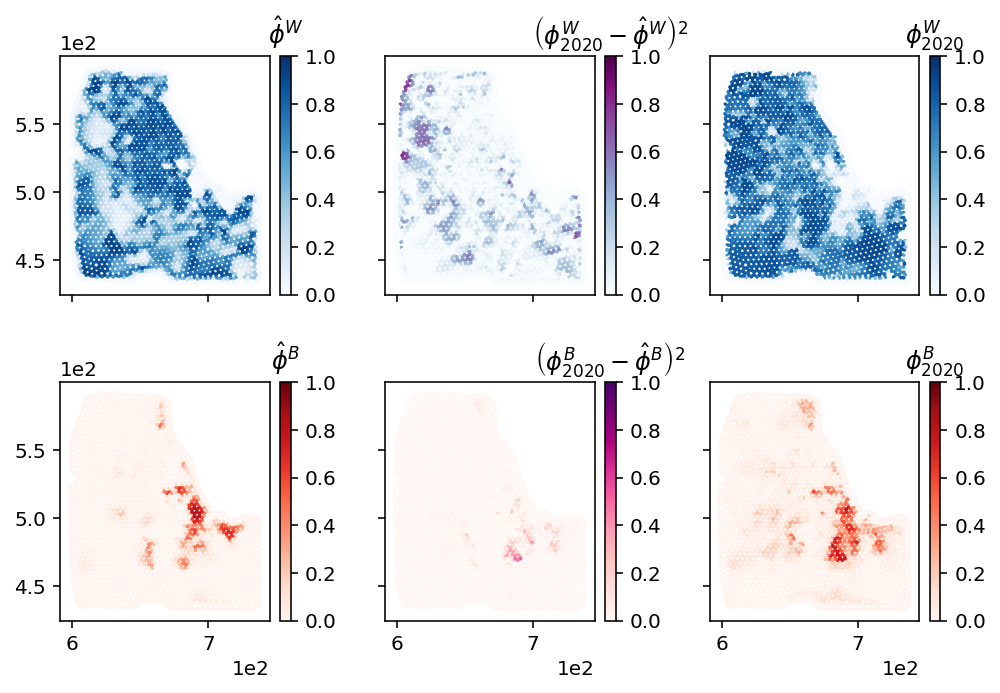

In [16]:
fig, ax = plt.subplots(2, 3, dpi=144, figsize=(7, 5), sharey=True, sharex=True)

for a in ax.ravel(): 
    a.set_aspect(1)
    a.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

# initialize plot

### White population ###
# simulation
cw = ax[0, 0].scatter(cell_centers[:, 0], cell_centers[:, 1], c=ϕW_init,
                      s=1, cmap="Blues", vmin=0, vmax=1)
caxw = ax[0, 0].inset_axes([1.05, 0.0, 0.05, 1])
cbarw = fig.colorbar(cw, ax=ax[0, 0], cax=caxw)
cbarw.ax.set(title=r"$\hat{\phi}^W$")

# error between simulation and final
cw_error = ax[0, 1].scatter(cell_centers[:, 0], cell_centers[:, 1], c=(ϕW_init - ϕW_final)**2,
                            s=1, cmap="BuPu", vmin=0, vmax=1)
caxw_error = ax[0, 1].inset_axes([1.05, 0.0, 0.05, 1])
cbarw_error = fig.colorbar(cw_error, ax=ax[0, 1], cax=caxw_error)
cbarw_error.ax.set(title=r"$\left( \phi^W_\mathrm{2020} - \hat{\phi}^W \right)^2$")

# final population
cw_final = ax[0, 2].scatter(cell_centers[:, 0], cell_centers[:, 1], c=ϕW_final,
                            s=1, cmap="Blues", vmin=0, vmax=1)
caxw_final = ax[0, 2].inset_axes([1.05, 0.0, 0.05, 1])
cbarw_final = fig.colorbar(cw_final, ax=ax[0, 2], cax=caxw_final)
cbarw_final.ax.set(title=r"$\phi^W_\mathrm{2020}$")

### Black population ###
# simulation
cb = ax[1, 0].scatter(cell_centers[:, 0], cell_centers[:, 1], c=ϕB_init,
                      s=1, cmap="Reds", vmin=0, vmax=1)
caxb = ax[1, 0].inset_axes([1.05, 0.0, 0.05, 1])
cbarb = fig.colorbar(cb, ax=ax[1, 0], cax=caxb)
cbarb.ax.set(title=r"$\hat{\phi}^B$")

# error between simulation and final
cb_error = ax[1, 1].scatter(cell_centers[:, 0], cell_centers[:, 1], c=(ϕB_init - ϕB_final)**2,
                            s=1, cmap="RdPu", vmin=0, vmax=1)
caxb_error = ax[1, 1].inset_axes([1.05, 0.0, 0.05, 1])
cbarb_error = fig.colorbar(cb_error, ax=ax[1, 1], cax=caxb_error)
cbarb_error.ax.set(title=r"$\left( \phi^B_\mathrm{2020} - \hat{\phi}^B \right)^2$")

# final population
cb_final = ax[1, 2].scatter(cell_centers[:, 0], cell_centers[:, 1], c=ϕB_final,
                            s=1, cmap="Reds", vmin=0, vmax=1)
caxb_final = ax[1, 2].inset_axes([1.05, 0.0, 0.05, 1])
cbarb_final = fig.colorbar(cb_final, ax=ax[1, 2], cax=caxb_final)
cbarb_final.ax.set(title=r"$\phi^B_\mathrm{2020}$")

plt.tight_layout()

def animate(i):
    with h5py.File(os.path.join(savefolder, filename), "r") as d:
        group = list(d.keys())[i + 1]
        cw.set_array(d[group]["phiW"])
        cb.set_array(d[group]["phiB"])
        cw_error.set_array((d[group]["phiW"] - ϕW_final)**2)
        cb_error.set_array((d[group]["phiB"] - ϕB_final)**2)

    return [cw, cb, cw_error, cb_error]

anim = animation.FuncAnimation(fig, animate, frames=nt, interval=20, blit=True)
# anim.save(f"2024-04-22_T10000_Γ{Γ}.mp4")

HTML(anim.to_html5_video())


In [ ]:
n=0
print(f"n{n:07d}")

In [ ]:
datadict = {"n": 7, "phiB": np.random.randn(100), "phiW": np.random.rand(100)}
for key, value in datadict.items():
    print(value)

In [ ]:
ϕW, ϕB, x, y = get_data("/Users/danny/code/uchicago/sociohydro/data/raw/gridded/Illinois_Cook.hdf5")
x /= 1000
y /= 1000

ξ, _ = get_corrLength("/Users/danny/code/uchicago/sociohydro/data/raw/gridded/Illinois_Cook.hdf5", region="masked",
                      capacity_method="local", p0=[1, 10, 0])

# x /= ξ
# y /= ξ

In [ ]:
fig, ax = plt.subplots(1, 2, dpi=144, sharey=True)
ax[0].pcolormesh(x, y, ϕW, vmin=0, vmax=1, cmap="Blues")
ax[1].pcolormesh(x, y, ϕB, vmin=0, vmax=1, cmap="Reds")
for a in ax.ravel():
    a.set_aspect(1)

ax[0].set(xlabel=r"$x / \xi$", ylabel=r"$y / \xi$")

ax[1].set(xlabel=r"$x / \xi$")

In [ ]:
buffer = 5
simplify = 2
cellsize = 4
crs = "ESRI:102003"
mesh, simple_boundary, geo_file_contents = make_mesh(ϕW, x, y, crs, 
                                                     buffer, simplify, cellsize)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(mesh.cellCenters.value[0], mesh.cellCenters.value[1], s=1)
ax.contour(x, y, np.isnan(ϕW), levels=0)
ax.set_aspect(1)

In [ ]:
fig, ax = plt.subplots(2, 4, dpi=144, sharey=True, sharex=True)

# initial
ax[0, 0].scatter(mesh.cellCenters.value[0],
                 mesh.cellCenters.value[1],
                 c=ϕW_array[0], s=1, cmap="Blues",
                 vmin=0, vmax=1)
ax[1, 0].scatter(mesh.cellCenters.value[0],
                 mesh.cellCenters.value[1],
                 c=ϕB_array[0], s=1, cmap="Reds",
                 vmin=0, vmax=1)
ax[0, 0].set(title="initial", ylabel=r"$\phi^W$")

# final (true)
ax[0, 1].scatter(mesh.cellCenters.value[0],
                 mesh.cellCenters.value[1],
                 c=ϕWf_cell, s=1, cmap="Blues",
                 vmin=0, vmax=1)
ax[1, 1].scatter(mesh.cellCenters.value[0],
                 mesh.cellCenters.value[1],
                 c=ϕBf_cell, s=1, cmap="Reds",
                 vmin=0, vmax=1)
ax[0, 1].set(title="final (true)")

# final (sim)
ax[0, 2].scatter(mesh.cellCenters.value[0],
                 mesh.cellCenters.value[1],
                 c=ϕW_array[-1], s=1, cmap="Blues",
                 vmin=0, vmax=1)
ax[1, 2].scatter(mesh.cellCenters.value[0],
                 mesh.cellCenters.value[1],
                 c=ϕB_array[-1], s=1, cmap="Reds",
                 vmin=0, vmax=1)
ax[0, 2].set(title="final (sim)")

# difference
diffW = ax[0, 3].scatter(mesh.cellCenters.value[0],
                         mesh.cellCenters.value[1],
                         c=(ϕWf_cell - ϕW_array[-1]),
                         s=1, cmap="BrBG", vmin=-1, vmax=1)
caxW = ax[0, 3].inset_axes([1.05, 0.0, 0.05, 1])
cbarW = fig.colorbar(diffW, cax=caxW, ax=ax[0, 3])

diffB = ax[1, 3].scatter(mesh.cellCenters.value[0],
                         mesh.cellCenters.value[1],
                         c=(ϕBf_cell - ϕB_array[-1]),
                         s=1, cmap="BrBG", vmin=-1, vmax=1)
caxB = ax[1, 3].inset_axes([1.05, 0.0, 0.05, 1])
cbarB = fig.colorbar(diffB, cax=caxB, ax=ax[1, 3])


ax[0, 3].set(title="true - sim") 

for a in ax.ravel():
    a.set_aspect(1)
    a.ticklabel_format(axis="both", style="sci", scilimits=(0,0))


ax[1, 0].set(ylabel=r"$\phi^B$")

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(2, 3, dpi=144, sharey=True, sharex=True)

# initial
ax[0, 0].scatter(mesh.cellCenters.value[0],
                 mesh.cellCenters.value[1],
                 c=ϕW_array[0], s=1, cmap="Blues",
                 vmin=0, vmax=1)
ax[1, 0].scatter(mesh.cellCenters.value[0],
                 mesh.cellCenters.value[1],
                 c=ϕB_array[0], s=1, cmap="Reds",
                 vmin=0, vmax=1)
ax[0, 0].set(title="initial", ylabel=r"$\phi^W$")

# final (true)
ax[0, 1].scatter(mesh.cellCenters.value[0],
                 mesh.cellCenters.value[1],
                 c=ϕWf_cell, s=1, cmap="Blues",
                 vmin=0, vmax=1)
ax[1, 1].scatter(mesh.cellCenters.value[0],
                 mesh.cellCenters.value[1],
                 c=ϕBf_cell, s=1, cmap="Reds",
                 vmin=0, vmax=1)
ax[0, 1].set(title="final (true)")

# difference
diffW = ax[0, 2].scatter(mesh.cellCenters.value[0],
                         mesh.cellCenters.value[1],
                         c=ϕWf_cell - ϕW0_cell, s=1,
                         cmap="BrBG")
caxW = ax[0, 2].inset_axes([1.05, 0.0, 0.05, 1])
cbarW = fig.colorbar(diffW, cax=caxW, ax=ax[0, 2])

diffB = ax[1, 2].scatter(mesh.cellCenters.value[0],
                         mesh.cellCenters.value[1],
                         c=ϕBf_cell - ϕB0_cell, s=1,
                         cmap="BrBG")
caxB = ax[1, 2].inset_axes([1.05, 0.0, 0.05, 1])
cbarB = fig.colorbar(diffB, cax=caxB, ax=ax[1, 2])


ax[0, 2].set(title="final - initial") 

for a in ax.ravel():
    a.set_aspect(1)
    a.ticklabel_format(axis="both", style="sci", scilimits=(0,0))


ax[1, 0].set(ylabel=r"$\phi^B$")

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 2, dpi=144, sharey=True)
scat0 = ax[0].scatter(cell_points[:, 0], cell_points[:, 1],
                      c=ϕW0_cell + ϕB0_cell, s=1, vmin=0, vmax=1)
scatf = ax[1].scatter(cell_points[:, 0], cell_points[:, 1],
                      c=ϕWf_cell + ϕBf_cell, s=1, vmin=0, vmax=1)
cax = ax[1].inset_axes([1.05, 0.0, 0.05, 1])
cbar = fig.colorbar(scatf, ax=ax[1], cax=cax)
cbar.ax.set(title=r"$\phi^W + \phi^B$")

for a in ax.ravel():
    a.set_aspect(1)
    a.ticklabel_format(axis="both", style="sci", scilimits=(0,0))

In [ ]:
(ϕW0_cell + ϕB0_cell).mean()

In [ ]:
(ϕWf_cell + ϕBf_cell).mean()

# Check interpolation

In [ ]:
fig, ax = plt.subplots(1, 2, dpi=144, sharey=True)
simple_boundary.boundary.plot(ax=ax[0], color="k")
simple_boundary.boundary.plot(ax=ax[1], color="k")
scatW = ax[0].scatter(mesh.cellCenters.value[0],
                      mesh.cellCenters.value[1],
                      c=ϕW0_cell, s=1,
                      cmap="Blues", vmin=0, vmax=1)
cax0 = ax[0].inset_axes([1.05, 0.0, 0.05, 1])
cbar0 = fig.colorbar(scatW, ax=ax[0], cax=cax0)
cbar0.ax.set(title=r"$\phi^W$")
ax[0].ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

scatB = ax[1].scatter(mesh.cellCenters.value[0],
                      mesh.cellCenters.value[1],
                      c=ϕB0_cell, s=1,
                      cmap="Reds", vmin=0, vmax=1)
cax1 = ax[1].inset_axes([1.05, 0.0, 0.05, 1])
cbar1 = fig.colorbar(scatB, ax=ax[1], cax=cax1)
cbar1.ax.set(title=r"$\phi^B$")
ax[1].ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
plt.tight_layout()


# Measure gradient magnitudes

In [ ]:
import h5py

In [ ]:
datafile = "/Users/danny/code/uchicago/sociohydro/data/raw/gridded/Illinois_Cook.hdf5"
with h5py.File(datafile) as d:
    ρW = d["1990"]["white_grid_masked"][()]
    ρB = d["1990"]["black_grid_masked"][()]
    x_grid = d["1990"]["x_grid"][()]
    y_grid = d["1990"]["y_grid"][()]
    
    capacity = np.zeros(x_grid.shape)
    for key in d.keys():
        capacity = np.fmax(capacity, d[key]["white_grid_masked"][:] + d[key]["black_grid_masked"][:])
    
ϕW = ρW / (1.1 * capacity)
ϕB = ρB / (1.1 * capacity)

In [ ]:
fig, ax = plt.subplots(dpi=144, figsize=(3, 3))
ax.pcolormesh(x_grid, y_grid, ϕW, cmap="Blues", vmin=0, vmax=1)
ax.set_aspect(1)
ax.ticklabel_format(axis="both", style="sci", scilimits=(0,0))

In [ ]:
ϕWx, ϕWy = np.gradient(ϕW, 1000, 1000)
print([np.nanmin(ϕWx), np.nanmax(ϕWx)])
print([np.nanmin(ϕWy), np.nanmax(ϕWy)])

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3), dpi=144, sharey=True)
ax[0].pcolormesh(x_grid, y_grid, ϕW, cmap="Blues", vmin=0, vmax=1)
ax[1].pcolormesh(x_grid, y_grid, ϕWx, cmap="BuPu", vmin=-4e-4, vmax=4e-4)
ax[2].pcolormesh(x_grid, y_grid, ϕWy, cmap="BuPu", vmin=-4e-4, vmax=4e-4)
for a in ax.ravel():
    a.ticklabel_format(axis="both", style="sci", scilimits=(0,0))
